In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt

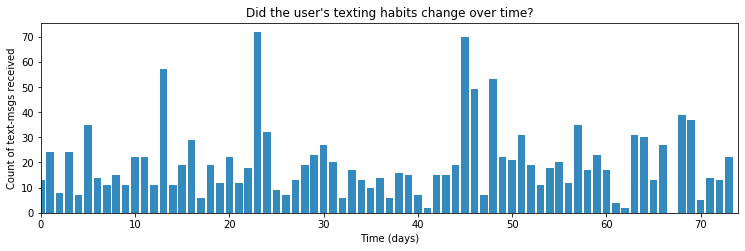

In [5]:
fig = plt.figure(figsize=(12.5, 3.5))
count_data = np.loadtxt('../Chapter1_Introduction/data/txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color='#348ABD')
plt.xlabel('Time (days)')
plt.ylabel('Count of text-msgs received')
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data-1)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
with model:
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. THe `swtich()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up til `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are *not* fixing any variables yet.

In [8]:
with model: 
    observations = pm.Poisson('obs', lambda_, observed=count_data)

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword.

In [9]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:12<00:00, 4716.43draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

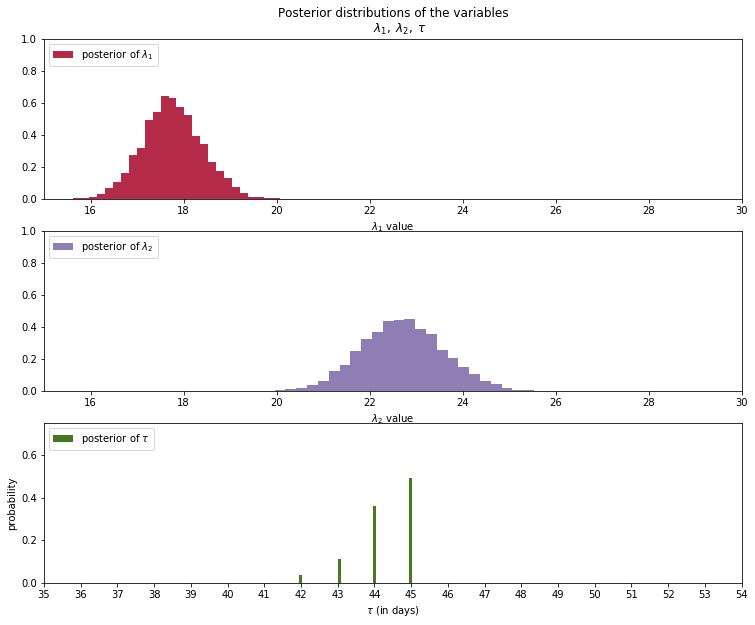

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
                  label='posterior of $\lambda_1$', color="#A60628", density=True)
plt.legend(loc='upper left')
plt.title(r"""Posterior distributions of the variables
    $\lambda_1, \; \lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel('$\lambda_1$ value')

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");


We'll use the posterior samples to answer the following question: what is the expected number of texts at day  $𝑡,0\le𝑡\le70$  ? Recall that the expected value of a Poisson variable is equal to its parameter  𝜆 . Therefore, the question is equivalent to what is the expected value of  𝜆  at time  𝑡 ?

In the code below, let  𝑖  index samples from the posterior distributions. Given a day  𝑡 , we average over all possible  $𝜆_𝑖$  for that day  𝑡 , using  $𝜆_𝑖=𝜆_{1,𝑖}$  if  $𝑡<𝜏_𝑖$  (that is, if the behaviour change has not yet occurred), else we use  $𝜆_𝑖=𝜆_{2,𝑖}$ .

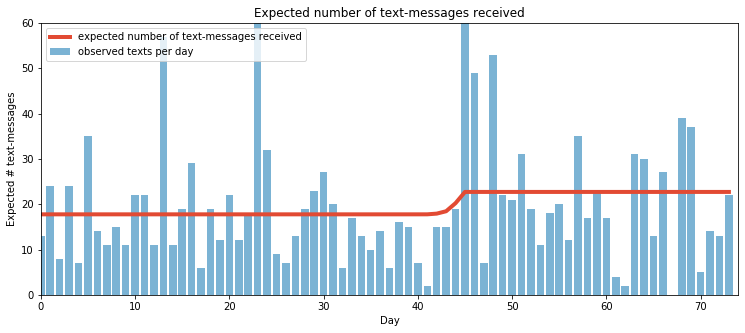

In [22]:
plt.figure(figsize=(12.5, 5))

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # For each day, that value of tau indicates whether we are 'before'
    # in the lambda1 'regime' or
    # after (in the lambda2 'regime') the switch point
    # by taking the posterior sample of lambda_1/2 accordingly, we can average 
    # overall samples to get an expected value for lambda on that day.
    # As explained, the 'message count' random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of 
    # 'message count'.
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                  + lambda_2_samples[~ix].sum()) / N
    

plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color='#E24A33',
        label='expected number of text-messages received')
plt.xlim(0, n_count_data)
plt.xlabel('Day')
plt.ylabel('Expected # text-messages')
plt.title('Expected number of text-messages received')
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color='#348ABD', alpha=0.65,
       label='observed texts per day')

plt.legend(loc='upper left');